In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class NumberLineSystem:
    """
    1D particle system with collision and potential field.

    State: x[t] = [y[t], v[t]]
    Input: u[t] ∈ [-1, 1]
    Output: z[t] = y[t] + measurement noise

    Dynamics:
    v[t+1] = 0           with probability p_c * |v[t]|/v_max
    v[t+1] = v[t] + (u[t] + f_φ(y[t]))/m + N(0, 0.01*v[t]^2) otherwise

    y[t+1] = y[t] + v[t+1] + N(0, 0.25*v[t+1]^2)
    """

    def __init__(self, m=1.0, p_c=0.1, v_max=5.0, y0=0.0, v0=0.0):
        self.m = m
        self.p_c = p_c
        self.v_max = v_max
        self.y = y0
        self.v = v0
        self.history = {'y': [y0], 'v': [v0], 'u':[0]}

    def f_phi(self, y):
        return 2*np.sin(y)

    def crash_probability(self, v):

        return self.p_c * abs(v) / self.v_max

    def step(self, u):
        # Apply collision dynamics
        if np.random.rand() < self.crash_probability(self.v):
            self.v = 0
        else:
            self.v = self.v + (u + self.f_phi(self.y))/self.m + np.random.normal(0, 0.01*self.v**2)

        # Apply position dynamics
        self.y = self.y + self.v + np.random.normal(0, 0.25*self.v**2)
        self.history['y'].append(self.y)
        self.history['v'].append(self.v)
        self.history['u'].append(u)

    def simulate(self, inputs):
        # Reset history for a new simulation
        self.history = {'y': [self.history['y'][0]], 'v': [self.history['v'][0]], 'u': [self.history['u'][0]]}
        results = []
        for u in inputs:
            results.append(self.step(u))
        return results

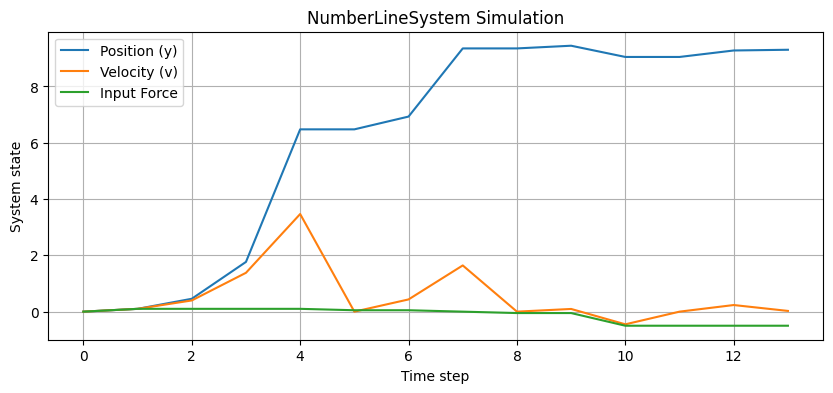

In [ ]:
system = NumberLineSystem(m=1.0, p_c=0.6, v_max=1.0, y0=0.0, v0=0.0)    # instantiate the class
# input_seq = np.random.uniform(-1, 1, 10)     # generate some random inputs
input_seq = [0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.0, -0.05, -0.05, -0.5, -0.5, -0.5, -0.5]
system.simulate(input_seq)                   # run simulation

T = len(system.history['y'])  # Number of (simulated) timesteps

plt.figure(figsize=(10,4))
plt.plot(range(T), system.history['y'], label='Position (y)')
plt.plot(range(T), system.history['v'], label='Velocity (v)')
plt.plot(range(T), system.history['u'], label='Input Force')
plt.xlabel('Time step')
plt.ylabel('System state')
plt.title('NumberLineSystem Simulation')
plt.legend()
plt.grid(True)
plt.show()